In [1]:
import abc
from collections import *
from dataclasses import dataclass
import enum
import gym
import heapq
import numpy as np
from typing import *

%matplotlib inline
import imageio
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
class Agent(abc.ABC):
    
    @abc.abstractmethod
    def get_action(self, env, state):
        pass


def try_agent(agent: Agent):
    with gym.make("CartPole-v0") as env:
        total_reward = 0.0
        obs = env.reset()
        env.render()
        done = False
        while not done:
            action = agent.get_action(env, obs)
            obs, reward, done, _ = env.step(action)
            total_reward += reward
            env.render()
        print("Total reward {0:.2f}".format(total_reward))

In [3]:
"""
Random agent
"""

class RandomAgent(Agent):
    def get_action(self, env, state):
        return env.action_space.sample()


try_agent(RandomAgent())

Total reward 47.00


In [4]:
"""
Manual agent (does not take account of speed)
"""


class BrutalAgent(Agent):
    def get_action(self, env, state):
        x, x_dot, theta, theta_dot = state
        if theta < 0.02:
            return 0
        elif theta > 0.02:
            return 1
        return 0


try_agent(BrutalAgent())

Total reward 57.00


In [ ]:
"""
Application of PID circuit (limited to linear systems)
"""


# How you do it in the industry

In [11]:
"""
Cross Entropy Method:
- Start with a random policy
- Play N episodes with the current policy
- Take the episodes above a reward boundary (typically percentile 70th)
- Train on these "Elite" episodes (throw away the uninteresting ones)
=> Look like a kind of genetic algorithm stuff
"""


class Policy(abc.ABC):
    def get_action(self, state) -> 'action':
        pass
    
    def improve(self, episodes: List[Tuple['states', 'actions', 'reward']]):
        pass


class CrossEntropyAgent(Agent):
    def __init__(self, policy: Policy, epsilon: float = 0.1):
        self.epsilon = epsilon
        self.policy = policy
    
    def get_action(self, env, state):
        if self.epsilon > 0. and np.random.random() < self.epsilon:
            return env.action_space.sample()
        return self.policy.get_action(state)
    
    def fit(self, env,
            max_iteration: int = 100,
            epsilon_decrease: float = 0.,
            batch_size: int = 1000,
            batch_threshold: float = 0.7) -> List[float]:
        mean_scores = []
        for _ in range(max_iteration):
            episodes = [self._play_episode(env) for _ in range(batch_size)]
            mean_score = np.mean([episode[-1] for episode in episodes])
            mean_scores.append(mean_score)
            print("Mean score:", mean_score)
            if mean_score >= 200:
                break
            
            episodes.sort(key=lambda t: t[-1])
            episodes = episodes[int(batch_threshold*batch_size):]
            self.policy.improve(episodes)
            self.epsilon -= epsilon_decrease
        return mean_scores
    
    def _play_episode(self, env):
        states, actions = [], []
        total_reward = 0.0
        state = env.reset()
        done = False
        while not done:
            action = self.get_action(env, state)
            states.append(state)
            actions.append(action)
            state, reward, done, _ = env.step(action)
            total_reward += reward
        return states, actions, total_reward

In [54]:
"""
Implementation of a policy to learn via a Neural Net
"""


import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data


class FullyConnectedNet(nn.Module):
    def __init__(self, observation_size, hidden_size, action_size):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(observation_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size))
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, observations, with_softmax = False):
        ys = self.fc(observations)
        if with_softmax:
            return self.softmax(ys)
        return ys


class NeuralNetPolicy(Policy):
    def __init__(self, iteration_nb: int, learning_rate: float):
        self.net = FullyConnectedNet(observation_size=4, hidden_size=150, action_size=2)
        self.iteration_nb = iteration_nb
        self.learning_rate = learning_rate
    
    def get_action(self, state) -> 'action':
        self.net.eval()
        xs = torch.FloatTensor(state)
        ys = self.net(xs, with_softmax=True)
        return torch.argmax(ys).item()
    
    def improve(self, episodes: List[Tuple['states', 'actions', 'reward']]):
        self.net.train()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.net.parameters(), lr=self.learning_rate)
        data_set = self._to_data_set(episodes)
        loader = data.DataLoader(data_set, batch_size=100, shuffle=True)
        for _ in range(self.iteration_nb):
            for states, actions in loader:
                optimizer.zero_grad()
                got = self.net(states, with_softmax=False)
                loss = criterion(got, actions)
                loss.backward()
                optimizer.step()

    def _to_data_set(self, episodes):
        xs, ys = [], []
        for states, actions, reward in episodes:
            for state, action in zip(states, actions):
                xs.append(state)
                ys.append(action)
        
        xs = torch.FloatTensor(xs)
        ys = torch.LongTensor(ys)
        return data.TensorDataset(xs, ys)

Mean score: 10.8125
Mean score: 10.5625
Mean score: 12.0625
Mean score: 18.1875
Mean score: 23.5
Mean score: 32.5625
Mean score: 59.8125
Mean score: 99.8125
Mean score: 79.5625
Mean score: 110.25
Mean score: 109.5
Mean score: 135.3125
Mean score: 120.3125
Mean score: 131.8125
Mean score: 135.0
Mean score: 127.1875
Mean score: 154.0
Mean score: 151.4375
Mean score: 142.0625
Mean score: 149.6875
Mean score: 145.0625
Mean score: 136.75
Mean score: 158.0625
Mean score: 179.5625
Mean score: 184.375
Mean score: 129.625
Mean score: 112.375
Mean score: 145.1875
Mean score: 176.0625
Mean score: 167.375
Mean score: 196.0
Mean score: 181.4375
Mean score: 181.4375
Mean score: 188.875
Mean score: 166.3125
Mean score: 166.9375
Mean score: 185.0
Mean score: 108.9375
Mean score: 186.875
Mean score: 175.5625
Mean score: 173.625
Mean score: 199.6875
Mean score: 165.8125
Mean score: 187.3125
Mean score: 175.6875
Mean score: 192.625
Mean score: 194.8125
Mean score: 200.0


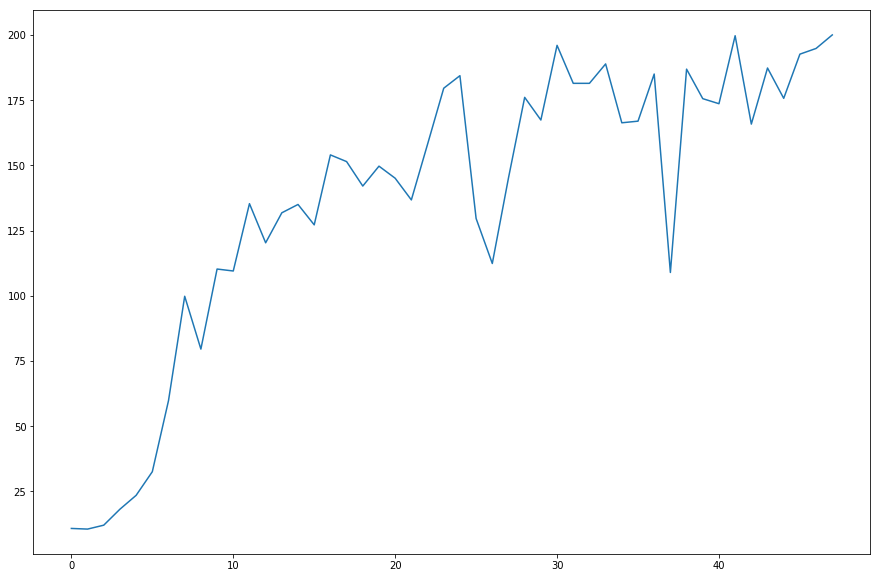

In [55]:
"""
Test with the policy of a neural net
"""


policy = NeuralNetPolicy(iteration_nb=50, learning_rate=1e-1)
agent = CrossEntropyAgent(policy, epsilon=0.2)
with gym.make("CartPole-v0") as env:
    scores = agent.fit(env, epsilon_decrease=0.1 / 100, max_iteration = 100, batch_size = 16, batch_threshold = 0.7)

plt.figure(figsize=(15, 10))
plt.plot(scores)
plt.show()

# agent.epsilon = 0.
# try_agent(agent)

In [37]:
"""
Implementation with feature engineering (polynomial) and a linear model
"""


class LinearNet(nn.Module):
    def __init__(self, observation_size, action_size):
        super().__init__()
        self.fc = nn.Linear(observation_size, action_size)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, observations, with_softmax = False):
        ys = self.fc(observations)
        if with_softmax:
            return self.softmax(ys)
        return ys


class PolynomialRegressionPolicy(Policy):
    def __init__(self, iteration_nb: int, learning_rate: float):
        observation_size = self._transform(np.zeros((4,))).shape[0]
        self.net = LinearNet(observation_size=observation_size, action_size=2)
        self.iteration_nb = iteration_nb
        self.learning_rate = learning_rate
    
    def get_action(self, state) -> 'action':
        self.net.eval()
        xs = torch.FloatTensor(self._transform(state))
        ys = self.net(xs, with_softmax=True)
        return torch.argmax(ys).item()
    
    def improve(self, episodes: List[Tuple['states', 'actions', 'reward']]):
        self.net.train()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.net.parameters(), lr=self.learning_rate)
        data_set = self._to_data_set(episodes)
        loader = data.DataLoader(data_set, batch_size=100, shuffle=True)
        for _ in range(self.iteration_nb):
            for states, actions in loader:
                optimizer.zero_grad()
                got = self.net(states, with_softmax=False)
                loss = criterion(got, actions)
                loss.backward()
                optimizer.step()
                
    def _to_data_set(self, episodes):
        xs, ys = [], []
        for states, actions, reward in episodes:
            for state, action in zip(states, actions):
                xs.append(self._transform(state))
                ys.append(action)
        
        xs = torch.FloatTensor(xs)
        ys = torch.LongTensor(ys)
        return data.TensorDataset(xs, ys)

    def _transform(self, state):
        new_state = list(state)
        k = len(state)
        for i in range(k-1):
            for j in range(i+1, k):
                new_state.append(state[i] * state[j])
        return np.array(new_state)

Mean score: 10.625
Mean score: 9.75
Mean score: 9.5625
Mean score: 9.625
Mean score: 9.8125
Mean score: 9.9375
Mean score: 9.8125
Mean score: 10.0625
Mean score: 9.75
Mean score: 9.6875
Mean score: 10.375
Mean score: 9.5
Mean score: 9.5625
Mean score: 10.0
Mean score: 10.9375
Mean score: 10.5625
Mean score: 10.6875
Mean score: 10.4375
Mean score: 9.4375
Mean score: 9.875
Mean score: 9.875
Mean score: 10.1875
Mean score: 10.25
Mean score: 10.125
Mean score: 9.375
Mean score: 9.5
Mean score: 9.75
Mean score: 10.125
Mean score: 15.0
Mean score: 14.625
Mean score: 25.1875
Mean score: 71.75
Mean score: 117.3125
Mean score: 117.0
Mean score: 176.1875
Mean score: 188.1875
Mean score: 200.0


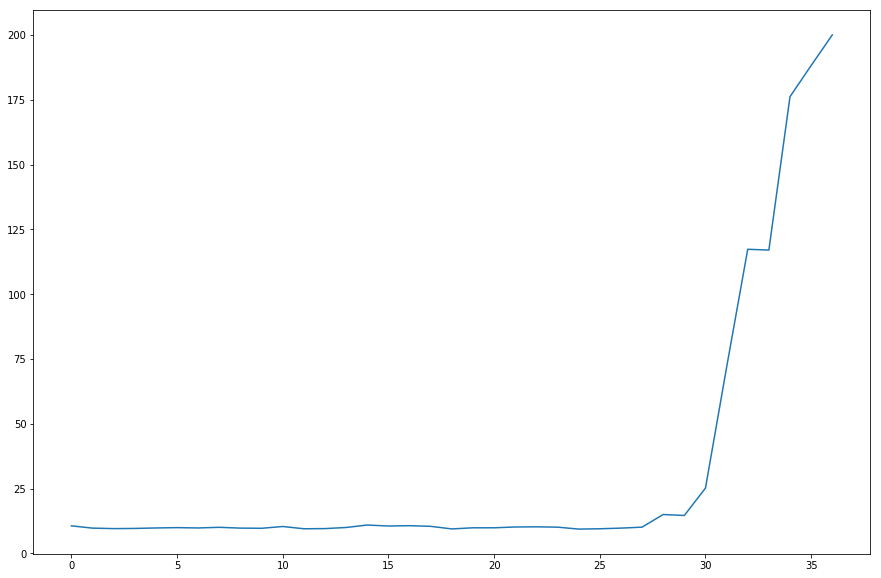

In [43]:
"""
Test with the policy of polynomial regression
"""


policy = PolynomialRegressionPolicy(iteration_nb=50, learning_rate=1e-1)
agent = CrossEntropyAgent(policy, epsilon=0.1)
with gym.make("CartPole-v0") as env:
    scores = agent.fit(env, epsilon_decrease=0., max_iteration = 100, batch_size = 16, batch_threshold = 0.7)

plt.figure(figsize=(15, 10))
plt.plot(scores)
plt.show()

# agent.epsilon = 0.
# try_agent(agent)